In [1]:
pip install pmdarima

     |████████████████████████████████| 1.4 MB 4.4 MB/s 
     |████████████████████████████████| 9.8 MB 34.2 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [2]:
import pandas as pd
import numpy as np
import datetime as datetime
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.offline as py
py.init_notebook_mode(connected=True)
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from matplotlib import pyplot
from math import sqrt
from sklearn.metrics import mean_squared_error
from tensorflow.keras.layers import LSTM
%matplotlib inline
import os
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose 
from pmdarima import auto_arima                        
from statsmodels.tools.eval_measures import rmse
import warnings
warnings.filterwarnings("ignore")

In [4]:
data_2020 = pd.read_csv('drive/MyDrive/Colab Notebooks/data/2020.csv')

In [5]:
data_2020.head()

,Time (CET),Actual Total Load [MW]
0,01.01.2020 00:00 - 01.01.2020 00:15,4374
1,01.01.2020 00:15 - 01.01.2020 00:30,4324
2,01.01.2020 00:30 - 01.01.2020 00:45,4284
3,01.01.2020 00:45 - 01.01.2020 01:00,4220
4,01.01.2020 01:00 - 01.01.2020 01:15,4173


In [6]:
data_2020.tail()

,Time (CET),Actual Total Load [MW]
35135,31.12.2020 22:45 - 31.12.2020 23:00,4441
35136,31.12.2020 23:00 - 31.12.2020 23:15,4415
35137,31.12.2020 23:15 - 31.12.2020 23:30,4358
35138,31.12.2020 23:30 - 31.12.2020 23:45,4378
35139,31.12.2020 23:45 - 01.01.2021 00:00,4356


In [7]:
data_2020 = data_2020.reset_index()
data_2020 = data_2020.drop(columns = "index", axis = 1)

In [8]:
# Removing duplicates
data_2020 = data_2020.drop_duplicates(subset="Time (CET)")

In [9]:
data_2020 = data_2020.drop(columns = "Time (CET)", axis = 1) #remove Time column in data and replacing with meaningful datetime 

In [10]:
data_2020['datetime'] = pd.date_range(start='01-01-2020t00:00', periods=len(data_2020), freq="15min")  #specifying datetime
data_2020 = data_2020[['datetime', 'Actual Total Load [MW]']]

In [11]:
data_2020 = data_2020.set_index('datetime')

In [12]:
data_2020.head()

,Actual Total Load [MW]
datetime,
2020-01-01 00:00:00,4374
2020-01-01 00:15:00,4324
2020-01-01 00:30:00,4284
2020-01-01 00:45:00,4220
2020-01-01 01:00:00,4173


In [13]:
data_2020.tail()

,Actual Total Load [MW]
datetime,
2020-12-31 22:45:00,4441
2020-12-31 23:00:00,4415
2020-12-31 23:15:00,4358
2020-12-31 23:30:00,4378
2020-12-31 23:45:00,4356


Perfect data without missing values


In [14]:
# converting the data from 15 min periods into 1 hour periods
hourly_2020 = data_2020.iloc[0::4, :] # keeping every 4 sample starting from 0

In [15]:
hourly_2020.head(5)

,Actual Total Load [MW]
datetime,
2020-01-01 00:00:00,4374
2020-01-01 01:00:00,4173
2020-01-01 02:00:00,3896
2020-01-01 03:00:00,3671
2020-01-01 04:00:00,3552


In [16]:
hourly_2020.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8784 entries, 2020-01-01 00:00:00 to 2020-12-31 23:00:00
Data columns (total 1 columns):
 #   Column                  Non-Null Count  Dtype
---  ------                  --------------  -----
 0   Actual Total Load [MW]  8784 non-null   int64
dtypes: int64(1)
memory usage: 137.2 KB


In [17]:
# Prediction with LSTM for a whole year

In [18]:
data = hourly_2020

In [19]:
MA24 = data.rolling(24*7).mean()

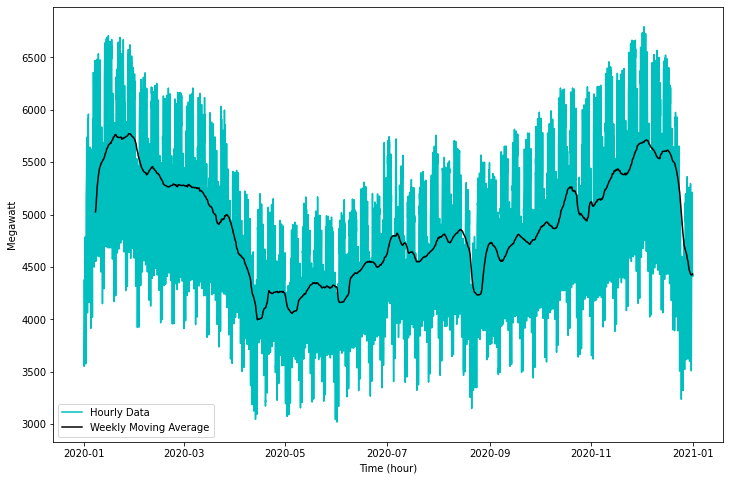

In [20]:
plt.figure(figsize=(12,8))
plt.plot(data, color='c', label='Hourly Data')
plt.plot(MA24, color='k', label='Weekly Moving Average')
plt.xlabel("Time (hour)")
plt.ylabel("Megawatt")
plt.savefig("yearly plot.png" , dpi=500)
plt.legend()
plt.show()

In [21]:
#Use MinMaxScaler to normalize data to range from 0 to 1
from sklearn.preprocessing import MinMaxScaler
values = data.values.reshape(-1,1)
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(values)

In [22]:
data.max(), data.min(), data.mean()

(0.99999994, 0.0, 0.49414918)

In [23]:
data.shape[0]

8784

In [24]:
# (batch, seq_length=60, features=1)
def make_timeseries_instances(data, seq_length=60):
  # to be done
  X = []
  Y = []
  for start in range(0, data.shape[0]-seq_length):
    X.append(data[start:start+seq_length])
    Y.append(data[start+seq_length])
  X = np.array(X)
  Y = np.array(Y)
  return X, Y

In [25]:
seq_length=60 
X,Y = make_timeseries_instances(data, seq_length=seq_length)
#X = X.reshape(960,40,-1)
#X = np.expand_dims(X,-1)
X = np.atleast_3d(X)
Y = np.expand_dims(Y, axis=-1)
print(X.shape)
print(Y.shape)

(8724, 60, 1)
(8724, 1, 1)


In [26]:
model = Sequential()
model.add(LSTM(16, input_shape=(seq_length, 1)))
model.add(Dense(1, activation='linear'))

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 16)                1152      
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 1,169
Trainable params: 1,169
Non-trainable params: 0
_________________________________________________________________


In [28]:
model.compile(loss='mse', optimizer='adam', metrics=['mae'])

In [29]:
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', 
                   patience=5, verbose=1,
                   restore_best_weights=True)

history = model.fit(X,Y, batch_size=32, validation_split=0.2, callbacks=[es], epochs=30)

Epoch 1/30
219/219 [==============================] - 8s 26ms/step - loss: 0.0266 - mae: 0.1259 - val_loss: 0.0202 - val_mae: 0.1236
Epoch 2/30
219/219 [==============================] - 5s 23ms/step - loss: 0.0088 - mae: 0.0756 - val_loss: 0.0076 - val_mae: 0.0658
Epoch 3/30
219/219 [==============================] - 5s 23ms/step - loss: 0.0053 - mae: 0.0579 - val_loss: 0.0041 - val_mae: 0.0521
Epoch 4/30
219/219 [==============================] - 5s 23ms/step - loss: 0.0039 - mae: 0.0490 - val_loss: 0.0025 - val_mae: 0.0369
Epoch 5/30
219/219 [==============================] - 5s 23ms/step - loss: 0.0027 - mae: 0.0394 - val_loss: 0.0021 - val_mae: 0.0353
Epoch 6/30
219/219 [==============================] - 5s 23ms/step - loss: 0.0020 - mae: 0.0332 - val_loss: 0.0022 - val_mae: 0.0382
Epoch 7/30
219/219 [==============================] - 5s 24ms/step - loss: 0.0017 - mae: 0.0312 - val_loss: 0.0017 - val_mae: 0.0322
Epoch 8/30
219/219 [==============================] - 5s 23ms/step - 

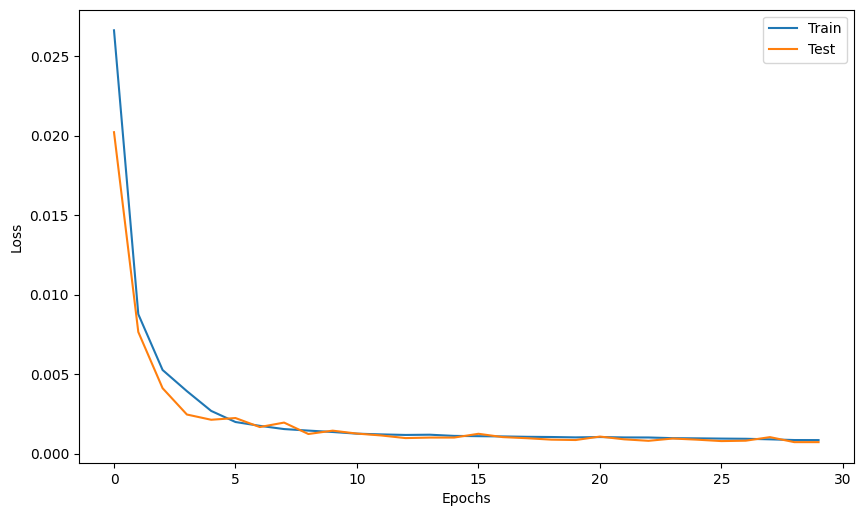

In [30]:
#Plot line graph to show amount loss according the the epoch
plt.figure(figsize=(10,6), dpi=100)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Test')
plt.legend()
plt.show()

In [31]:
preds = model.predict(X)

In [32]:
Y.shape , preds.shape

((8724, 1, 1), (8724, 1))

In [33]:
Y = Y.reshape(8724,1)

In [34]:
#Scaler Inverse Y back to normal value
preds_inv = scaler.inverse_transform(preds.reshape(-1, 1))
Y_inv = scaler.inverse_transform(Y.reshape(-1, 1))

In [35]:
#Convert X to dates¶
predictDates = hourly_2020.tail(len(preds_inv)).index

In [36]:
Y_reshape = Y_inv.reshape(len(Y_inv))
pred_reshape = preds_inv.reshape(len(preds_inv))

In [38]:
Y_reshape.shape

(8724,)

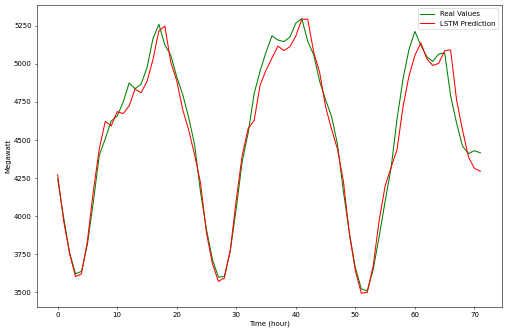

In [65]:
plt.figure(figsize=(12,8), dpi = 50)
plt.xlabel("Time (hour)")
plt.ylabel("Megawatt")
plt.plot(Y_reshape[8652:], color='g', label='Real Values')
plt.plot(pred_reshape[8652:], color='r', label='LSTM Prediction')
plt.legend()
plt.show()

**ARIMA MODEL**

In [40]:
december= hourly_2020.loc['12/1/2020  12:00:00 AM':'1/1/2021  12:00:00 AM']
df = december

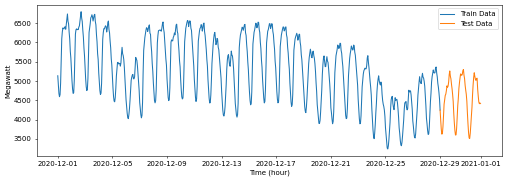

In [64]:
split_date = '12/29/2020  12:00:00 AM'
df_train = df[:'12/29/2020  12:00:00 AM']
df_test = df['12/29/2020  12:00:00 AM':]
plt.figure(figsize=(12,4),dpi=50)
plt.ylabel("Megawatt")
plt.xlabel("Time (hour)")
plt.plot(df_train)
plt.plot(df_test)
plt.legend(["Train Data", "Test Data"])

In [42]:
a = seasonal_decompose(df["Actual Total Load [MW]"], model = "add")

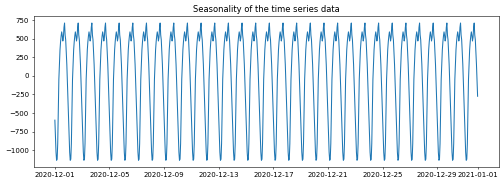

In [60]:
plt.figure(figsize=(12,4),dpi=50)
plt.title("Seasonality of the time series data")
plt.plot(a.seasonal)

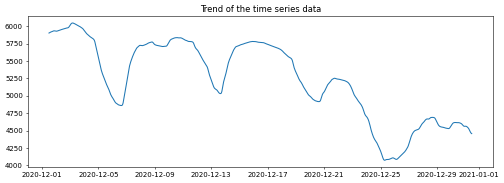

In [61]:
plt.figure(figsize=(12,4),dpi=50)
plt.title("Trend of the time series data")
plt.plot(a.trend)

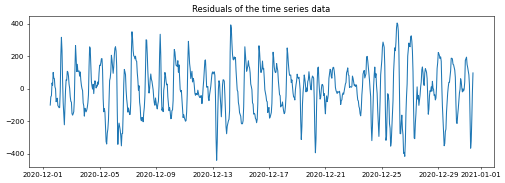

In [62]:
plt.figure(figsize=(12,4),dpi=50)
plt.title("Residuals of the time series data")
plt.plot(a.resid)

In [46]:
train = df.loc['12/1/2020':'12/29/2020']
test = df.loc['12/29/2020':]

In [47]:
stepwise_model = auto_arima(df, 
                            start_p=1, 
                            start_q=1, 
                            max_p=3, 
                            max_q=3, 
                            m=12, 
                            start_P=0, 
                            seasonal=True, 
                            d=1, D=1, 
                            trace=True, 
                            error_action='ignore',
                            suppress_warnings=True, 
                            stepwise=True)
print(stepwise_model.aic())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=2.76 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=10634.434, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=inf, Time=1.69 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=2.61 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=inf, Time=0.30 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=inf, Time=1.20 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=8512.066, Time=0.80 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=4.95 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=8387.961, Time=4.66 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=9376.493, Time=9.14 sec
 ARIMA(0,1,0)(2,1,2)[12]             : AIC=8385.587, Time=8.73 sec
 ARIMA(1,1,0)(2,1,2)[12]             : AIC=8098.246, Time=18.13 sec
 ARIMA(1,1,0)(1,1,2)[12]             : AIC=inf, Time=10.14 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=15.78 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=8237.214, Ti

In [48]:
stepwise_model.fit(train)

ARIMA(order=(3, 1, 1), scoring_args={}, seasonal_order=(1, 1, 2, 12),
      suppress_warnings=True, with_intercept=False)

In [49]:
forecast = stepwise_model.predict(n_periods=72)


In [50]:
ARIMA_prediction_last_3_days = pd.DataFrame(forecast)

In [51]:
ARIMA_prediction_last_3_days = ARIMA_prediction_last_3_days.set_index(test.index)

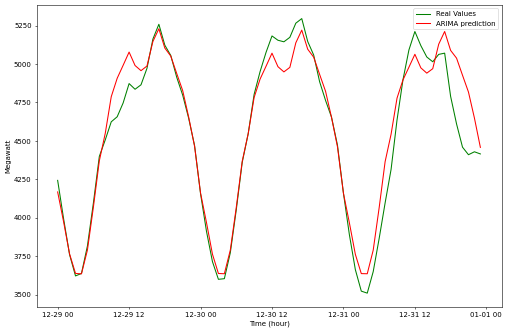

In [63]:
plt.figure(figsize=(12,8), dpi=50)
plt.plot(test, color='g', label='Real Values')
plt.xlabel("Time (hour)")
plt.ylabel("Megawatt")
plt.plot(ARIMA_prediction_last_3_days, color='r', label='ARIMA prediction')
plt.legend()
plt.show()

In [53]:
LSTM_prediction_last_3_days = pred_reshape [len(pred_reshape)-len(test):]
df_LSTM = pd.DataFrame(LSTM_prediction_last_3_days)
LSTM_prediction_last_3_days = df_LSTM.set_index(test.index)


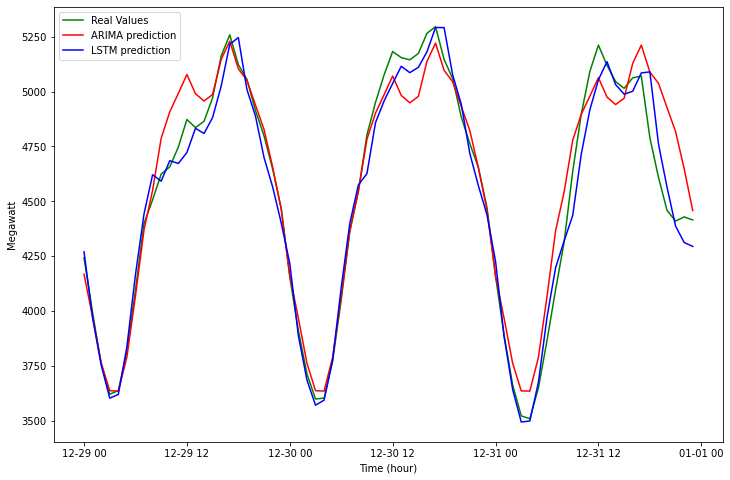

In [54]:
plt.figure(figsize=(12,8))
plt.plot(test, color='g', label='Real Values')
plt.xlabel("Time (hour)")
plt.ylabel("Megawatt")
plt.plot(ARIMA_prediction_last_3_days, color='r', label='ARIMA prediction')
plt.plot(LSTM_prediction_last_3_days, color='b', label="LSTM prediction")
plt.legend()
plt.show()

In [55]:
rmse1 = sqrt(mean_squared_error(test, LSTM_prediction_last_3_days))
rmse2 = sqrt(mean_squared_error(test, ARIMA_prediction_last_3_days))
print('Test RMSE for LSTM: %.3f' % rmse1)
print('Test RMSE for ARIMA: %.3f' % rmse2)



Test RMSE for LSTM: 89.405
Test RMSE for ARIMA: 142.267
